# Robust Methods

In [1]:
import scipy.stats as stats
import pylab
import numpy as np
import pandas as pd
import statsmodels.api as sm
import mplfinance as fplt
import math
from matplotlib import pyplot as plt
import scipy
import BarSampler as bs
def get_log_return(df):
    log_returns = pd.Series(np.log((df['close'] - df['open'])/df['open'] + 1),name='log returns')
    return pd.concat([df,log_returns], axis=1)

Statistical inferences are based only in part upon the observations. An equally important base is formed by prior assumptions about the underlying situation. Even in the simplest cases, there are explicit or implicit assumptions about randomness and independence, about distributional models, perhaps prior distributions for some unknown parameters, and so on. These assumptions are not supposed to be exactly true-they are mathematically convenient rationalizations of an often fuzzy knowledge or belief. As in every other branch of applied mathematics, such rationalizations or simplifications are vital, and one justifies their use by appealing to a vague continuity or stability principle: a minor error in the mathematical model should cause only a small error in the final conclusions. This can be very dangerous in practice!

Consider the following example from Tukey's famous EDA (1960). Assume that we have a large, randomly mixed batch of $n$ “good” and “bad” observations $x_i$ of the same quantity $\mu$. Each single observation with probability $1-\epsilon$ is a "good" one, and with probability $\epsilon$ is a "bad" one, where $\epsilon$ is a very small number. In the good case suppose $x_i$ is $\mathcal{N}(\mu,\sigma^2)$ and in the bad case $\mathcal{N}(\mu,9\sigma^2)$. Thus the errors of some are increased by a factor of 3. 

An equivalent statement would be that the $x_i$ are iid with distribution
$$F(x) = (1-\epsilon)\Phi\left(\frac{x-\mu}{\sigma}\right)+\epsilon\;\Phi\left(\frac{x-\mu}{3\sigma}\right)$$

where $\Phi$ is the cdf of the standard normal random variable. Note that this mixture is slightly fatter tailed than a normal distribution. Now let us consider the following two measures of scatter. The first is the mean absolute deviation
$$d_n = \frac{1}{n}\Sigma |x_i - \bar{x}|$$

and the second the root mean square deviation
$$s_n = \left[\frac{1}{n}\Sigma(x_i - \bar{x})^2\right]^{1/2}$$

Now it can be shown that if the errors are normal $s_n$ will converge to $\sigma$ while $d_n$ will converge to $\sqrt{\frac{2}{\pi}} \sigma$. In 1920 Fisher pointed out that if the observations are iid normal $s_n$ is about 12% more efficient than $d_n$. To compare the two we can use the asymptotic relative efficiency of $d_n$ relative to $s_n$

$$ARE(\epsilon)=\lim_{n\to\infty} \frac{var(s_n)/E(s_n)^2}{var(d_n)/E(d_n)^2} = \frac{\frac{1}{4}\left[\frac{3(1-80\epsilon)}{(1-8\epsilon)^2}-1\right]}{\frac{\pi(1+8\epsilon)}{2(1+2\epsilon)^2}-1}$$

This result can be used to show that an $\epsilon = 0.002$ produces $ARE(0.002)=1.016$. Thus the 12% advantage $s_n$ is overcome by an $\epsilon = 0.002$, or said another way 2 bad observations in 1000 are enough to overcome the relative quality of the estimator. Realize that even if the idealized model were true, the natural deviations are enough to render the asymptotic estimates useless. In practice $d_n$ is the preferable estimator. The issue here is one of fat tails. The excess kurtosis causes the variance of the classical estimator $s_n$ to explode. As we know a high kurtosis is characterized by a small number of data points. One could then ask the question why not
1. clean the data by removing outliers.
2. apply classical estimators and test to the cleaned data.


Although there are situations where you do what to take this approach, there can be problems with it.
1. It is usually hard to seperate these steps. For example in multi regression problems it is hard to properly identify outliers without robust parameter estimates.
2. Even if the original batch of observations consists of normal observations interspersed with some gross errors, the cleaned data will not be normal (there will be statistical errors of both kinds: false rejections and false retentions), and the situation is even worse when the original batch derives from a genuine nonnormal distribution, instead of from a gross-error framework. Therefore the classical normal theory is not applicable to cleaned samples, and the actual performance of such a two-step procedure may be more difficult to work out than that of a straight robust procedure.
3. It is an empirical fact that the best rejection procedures do not quite reach the performance of the best robust procedures. The latter apparently are superior because they can make a smooth transition between full acceptance and full rejection of an observation. See Hampel (1974a, 1985), and Hampel et al. (1986, pp. 56-71).
4. The same empirical study also had shown that many of the classical rejection rules are unable to cope with multiple outliers: it can happen that a second outlier masks the first, so that none is rejected.

## Univariate Data

We start with a simple example. Consider the following data set of natural logs of annual incomes in US dollars.

In [2]:
vnLogIncome = np.array([9.53,9.68,10.16,9.96,10.08,9.99,10.47,9.91,9.92,15.21])

Now let's make the assumption that $x_i \sim \mathcal{N}(\mu, \sigma^2)$ and check it with a qq-plot.

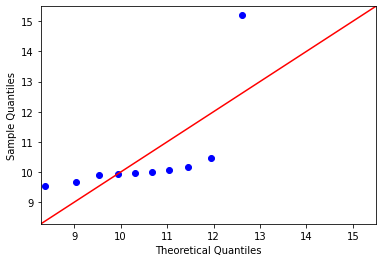

In [3]:
sm.qqplot(vnLogIncome,
          loc = vnLogIncome.mean(), scale = vnLogIncome.std(), 
          line='45')
pylab.show()

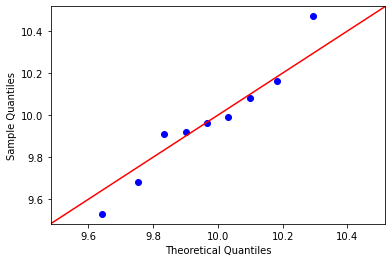

In [4]:
sm.qqplot(vnLogIncome[0:-1],
          loc = vnLogIncome[0:-1].mean(), scale = vnLogIncome[0:-1].std(), 
          line='45')
pylab.show()

Normality cannot be rejected for the 9 "regular" values. Now if we want to estimate measures of location and scale of this model we would like to use estimators which are robust. Let us consider some classical versus robust estimates of location. We will look at the sample mean verses the median.
$$\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i$$
$$Med(x)= \left\{
  \begin{array}{lr} 
      x_{(\frac{n+1}{2})} & n \; odd \\
      \frac{1}{2}(x_{(\frac{n}{2})} + x_{(\frac{n}{2}+1)}) & n\;even 
      \end{array}
      \right.$$

where $x_{(1)} \leq \ldots \leq x_{(n)}$ are the ordered observations. For classical versus robust estimates of scale we will look at the sample standard deviation versus the inter-quartile range.
$$s = \sqrt{\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2}$$
$$IQR(x) = \frac{1}{2 \Phi^{-1}(0.75)}(x_{(n-\left[n/4\right]+1)}-x_{(\left[n/4\right])})$$

In [5]:
vnLogIncome.mean()

10.491

In [6]:
np.median(vnLogIncome)

9.975000000000001

In [7]:
vnLogIncome[0:-1].mean()

9.966666666666667

In [8]:
np.median(vnLogIncome[0:-1])

9.96

In [9]:
vnLogIncome.std()

1.5914047253920045

In [10]:
stats.iqr(vnLogIncome)

0.22750000000000092

In [11]:
vnLogIncome[0:-1].std()

0.2543837870445192

In [12]:
stats.iqr(vnLogIncome[0:-1])

0.16999999999999993

A few observations. We see that classical estimators are highly influenced by outliers, where as robust estimators are not. Notice that the values for the robust estimates, in both cases, are close to the values for the classical estimates on the regular data. What we are driving towards is the development of estimators that are less influenced by outliers (robustness) and are precise on the uncontaminated data (efficiency). If we can achieve this it will naturally lead to a number of improvements to various techniques. Let's look at the simple case of outlier detection.

the classical theory says to normalized the observations via
$$z_i = \frac{x_i - \bar{x}}{s}$$
and if $|z_i| \geq 3$ we should flag $x_i$ as an outlier. Applying this to our data we find that

In [27]:
(vnLogIncome[-1] - vnLogIncome.mean())/vnLogIncome.std()

2.96530475541826

We can apply the same technique using our robust estimates
$$z_i = \frac{x_i - Med(x)}{IQR(x)}$$
We see that this gives us

In [28]:
(vnLogIncome[-1] - np.median(vnLogIncome))/stats.iqr(vnLogIncome)

23.010989010988915

This approach clear distinguishes the final data point as an outlier.

## Breakdown Value

As we have seen many of the classical estimators that people use have some kind of susceptibility to outliers. These estimators can "breakdown" in the presence of a small number of extreme data values. In order to measure how easily an estimator is effected by such phenomenon, i.e. how robust it is, we introduce the concept of a breakdown point. This comes in two flavors. The finite sample breakdown point of an estimator is the faction of data that can be given arbitrary values without making the estimator arbitrarily bad. Typically this is some faction of the sample size n. In order to remove dependance on the sample size we talk about the asymptotic breakdown point. This is the limit of the finite sample breakdown point as n goes to infinity. Let's consider a few examples in order to get an idea of how this works. We start with the sample mean
$$\bar{x} = \frac{x_1 + \cdots + x_n}{n}$$
It is easy to see that if we hold $x_1, \ldots, x_{n-1}$ fixed and let $x_n$ go to infinity that the sample mean goes to infinity. This means that it only takes one bad outlier to ruin the sample mean. Thus the finite sample breakdown point is $1/n$ and the asymptotic breakdown point is zero. This is the worst case scenario. Next let's turn to the sample median. Again if we have $n$ data points and we let $(n-1)/2$ go to infinity well leaving the rest fixed, the sample median stays with the majority of the data points. This means that the finite sample breakdown point of the sample median is $(n-1)/(2n)$ and the asymptotic breakdown point is $1/2$. This is the best case scenario. Let's give a more formal defintion.

A data set with $n$ observations is given. If the estimator stays in a fixed bounded set even if we replace any $m − 1$ of the observations by any outliers, and this is no longer true for replacing any $m$ observations by outliers,then we say that the **breakdown value** of the estimator at that data set is $\frac{m}{n}$ and write
$$\epsilon_n^*(T_n,X_n)=\frac{m}{n}$$
to mean the breakdown value of the estimator $T_n$ on the collection of $n$ data points $X_n$.

A location estimator $\hat{\mu}$ is called **location equivariant** and **scale equivariant** if and only if
$$\hat{\mu}(aX_n + b) = a \hat{\mu}(X_n) +b$$
for all samples $X_n$ and all $a,b \in \mathbb{R}$ with $a \neq 0$

A scale estimator $\hat{\sigma}$ is called **location equivariant** and **scale equivariant** if and only if
$$\hat{\sigma}(aX_n + b) = |a| \hat{\sigma}(X_n)$$

For equivariant location estimators the breakdown value can be at most 50%
$$\epsilon_n^*(\hat{\mu},X_n) = \frac{1}{n}[\frac{n+1}{2}] \sim 50\%$$

Location and scale equivariance can be show for regression estimators in the univariate case.

One important issue is that although many single-parameter robust estimators happen to achieve reasonably high breakdown points, even if they were not designed to do so, this is not so with multiparameter estimation problems. In particular, all conventional regression estimates are highly sensitive to gross errors in the independent variables, and in extreme cases a single such error may cause breakdown.

## Sensitivity Curve

The **sensitivity curve** is a way to determine how much of an effect an outlier has on an estimator. It is a kind of visual diagnostic for robustness. It can also be used to asses the asymptotic normallity of an estimator. We can define sensitivity curve as follows. Assume that we have $n-1$ fixed data points $X_{n-1}=\{x_1, \ldots,x_{n-1}\}$. We want to see what happens the estimator $T$ if we add any real number $x$ to the set. We can do this by plotting the sensitivity curve
$$SC(T,X_{n-1},x) = \frac{T(x_1,\ldots ,x_{n-1},x)-T(x_1,\ldots ,x_{n-1})}{1/n}$$
where we allow $x$ to range over an interval containing $X_{n-1}$

In the case of the mean we have $SC(\bar{x},X_{n-1},x) = x-\bar{x}_{n-1}$

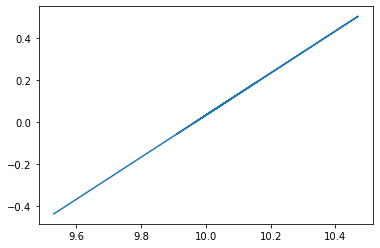

In [14]:
x = vnLogIncome[0:-1]
y = vnLogIncome[0:-1] - vnLogIncome[0:-1].mean()
plt.plot(x,y)

Here is the sensitivity curve for the median.

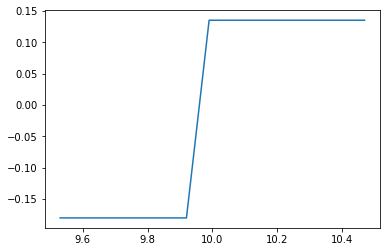

In [15]:
y = np.array([])
x = np.sort(x)
for i in x:
    newX = np.append(x,i)
    y = np.append(y,(np.median(newX) - np.median(x))*len(x))
plt.plot(x,y)

## Influence Function

The influence function is the asymptotic version of the sensitivity curve. It is computed for an estimator $T$ at a certain distribution $F$, and does not depend on a specific data set. For this purpose, the estimator should be written as a function of a distribution $F$. For example $T(F) = E_{F}(X)$ is the functional version of the sample mean, and $T(F) = F^{-1}(0.5)$ is the functional version of the sample median. The influence function measures how $T(F)$ changes when contamination is added in $x$. The contaminated distribution is written as 
$$F_{\epsilon,x} = (1 - \epsilon)F + \epsilon \Delta_x$$

where $\epsilon > 0$ and $\Delta_x$ is the distribution that puts all it's mass at $x$.

The **infulence function** is defined by
$$IF(x,T,F) = \lim_{\epsilon \rightarrow 0}\frac{T(F_{\epsilon,x})-T(F)}{\epsilon} = \frac{\partial}{\partial \epsilon}T(F_{\epsilon,x})|_{\epsilon = 0}$$

For example if we consider the mean $T(F)=E_F(X)$ at a distribution $F$ with finite first moment then
$$IF(x,T,F) = \frac{\partial}{\partial \epsilon}E((1-\epsilon)F+ \epsilon \Delta_x)|_{\epsilon = 0} = x -T(F)$$

In the case that $F = \Phi$ we find that $IF(x,T,\Phi)=x$. We will see that we prefer the properties of estimators with bounded influence functions.